In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd

from copy import deepcopy
from tqdm.notebook import tqdm

In [2]:
def runge_kutta(time_steps, y0, system, params):
    ys = [y0]
    for t in range(len(time_steps)-1):
        dt = time_steps[t+1]-time_steps[t]
        t0 = time_steps[t]
        t1 = time_steps[t+1]
        k1 = system(t0, y0, params)
        k2 = system(t0 + dt/2, y0 + dt / 2 * k1, params)
        k3 = system(t0 + dt/2, y0 + dt / 2 * k2, params)
        k4 = system(t1, y0 + dt * k3, params)
        y0  = y0 + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        ys.append(y0)
    return np.array(ys)

def lorentz_ode(t, xyz, params):
    x, y, z = xyz
    σ = params['σ']
    ρ = params['ρ']
    β = params['β']
    
    dx = σ * (y - x)
    dy = x * (ρ - z) - y
    dz = x * y - β * z
    
    return np.array([dx, dy, dz])

def get_data(p1 = 10., p2 = 28., p3 = 8/3):
    time_steps = np.arange(0, 1500, 0.1)
    params = {'σ' : p1, 'ρ' : p2, 'β' : p3}
    xyz0 = np.array([1., 1., 1.])
    lorenz_solution = runge_kutta(time_steps, xyz0, lorentz_ode, params)
    x, y, z = lorenz_solution[2000:].T

    x = (x - min(x)) / (max(x) - min(x))
    return x

In [3]:
# Hyper params
L = 4
K = 10
eps = 0.01
beta = 1

train_points_number = 5000

In [4]:
# Builds matrix of patterns
z_vectors = np.array(list(product(np.arange(1, K + 1), repeat=L)))
patterns = np.cumsum(z_vectors, axis=1)
patterns = np.hstack([np.zeros((z_vectors.shape[0], 1)), patterns]).astype(int)

train_patterns_size = int(beta * patterns.shape[0])

# patterns = patterns[np.random.choice(np.arange(patterns.shape[0]), train_patterns_size)]

In [5]:
def sample_z_vector(pattern):
    vecs = []
    for j in range(train_points_number - pattern[-1]):
        vecs.append(y[pattern + j])
    return np.array(vecs)

In [6]:
def norm(a):
    return np.sqrt(np.sum(np.square(a), axis=1))

In [7]:
def predict_on_actual(X, predicted_points_number):
  global x, train_points_number, patterns, eps

  predictions = []
  for T in tqdm(range(train_points_number, train_points_number + predicted_points_number), desc="Actual predictions", leave=False):
      St = []
      for i in tqdm(range(patterns.shape[0]), desc="Inner loop", leave=False):
          normalized_actual = norm(X[i][:, :-1] - x[(patterns[i] + T - patterns[i][-1])[:-1]])
          St.extend(X[i][(normalized_actual < eps), :][:, -1])
      predicted_value = np.mean(St)
      predictions.append(predicted_value)
  return predictions

In [8]:
def predict_on_predicted(X, predicted_points_number):
  global x, train_points_number, patterns, eps

  x_with_predictions = deepcopy(x)
  predictions = []
  for T in tqdm(range(train_points_number, train_points_number + predicted_points_number), desc="Predictions", leave=False):
      St = []
      for i in tqdm(range(patterns.shape[0]), desc="Inner loop", leave=False):
          normalized_predicted = norm(X[i][:, :-1] - x_with_predictions[(patterns[i] + T - patterns[i][-1])[:-1]])
          St.extend(X[i][(normalized_predicted < eps), :][:, -1])
      predicted_value = np.mean(St)
      predictions.append(predicted_value)
      x_with_predictions[T] = predicted_value
  return predictions

In [9]:
def predict_with_demon(X, predicted_points_number):
  global x, train_points_number, patterns, eps

  x_with_predictions = deepcopy(x)
  predictions = []
  for T in tqdm(range(train_points_number, train_points_number + predicted_points_number), desc="Demon predictions", leave=False):
      St = []
      for i in tqdm(range(patterns.shape[0]), desc="Inner loop", leave=False):
          normalized_predicted = norm(X[i][:, :-1] - x_with_predictions[(patterns[i] + T - patterns[i][-1])[:-1]])
          St.extend(X[i][(normalized_predicted < eps), :][:, -1])
      predicted_value = np.mean(St)
      if abs(predicted_value - x[T]) > eps:
        predicted_value = np.inf
      predictions.append(predicted_value)
      x_with_predictions[T] = predicted_value
  return predictions

In [10]:
def plot_2_graphs(arr1, arr2, predicted_points_number):
  global x, train_points_number
  x_predicted = np.arange(train_points_number, train_points_number + predicted_points_number)
  plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 1)
  plt.plot(x_predicted, arr1, label="Predicted values")
  plt.plot(x_predicted, x[train_points_number : train_points_number + predicted_points_number], label="Actual values")
  plt.title("Predictions based on predicted values without demon")
  plt.legend(loc="lower right")

  plt.subplot(1, 2, 2)
  plt.plot(x_predicted, arr2, label="Predicted values", marker='.')
  plt.plot(x_predicted, x[train_points_number : train_points_number + predicted_points_number], label="Actual values")
  plt.title("Predictions based on predicted values with demon")
  plt.legend(loc="lower right")

  plt.tight_layout()
  plt.show()

In [11]:
params_list = np.array([
    [10. * 0.99, 28., 8/3],
    [10., 28. * 0.99, 8/3],
    [10., 28., 8/3 * 0.99],
    [10. * 1.01, 28., 8/3],
    [10., 28. * 1.01, 8/3],
    [10., 28., 8/3 * 1.01]
])

In [ ]:
for params in params_list[:3]:
    x = get_data()
    y = get_data(*params) # train data

    plt.figure(figsize=(12, 6))
    plt.plot(x[-1000:], label="Original params: 10.0, 28.0, 2.667")
    plt.plot(y[-1000:], label=f"Params: {round(params[0], 3)}, {round(params[1], 3)}, {round(params[2], 3)}")
    plt.legend(loc="lower right")
    plt.show()

    # Splitting data
    points_number = y.shape[0]

    # Calculates matrix of patterns' arrays
    z_vectors_list = []
    for i in tqdm(range(patterns.shape[0]), desc="Computing matrix of Z-vectors", leave=False):
        z_vectors_list.append(sample_z_vector(patterns[i]))

    predicted_points_number = 50

    predictions_based_on_predicted = predict_on_predicted(z_vectors_list, predicted_points_number)
    demon_predictions = predict_with_demon(z_vectors_list, predicted_points_number)

    plot_2_graphs(predictions_based_on_predicted, demon_predictions, predicted_points_number)

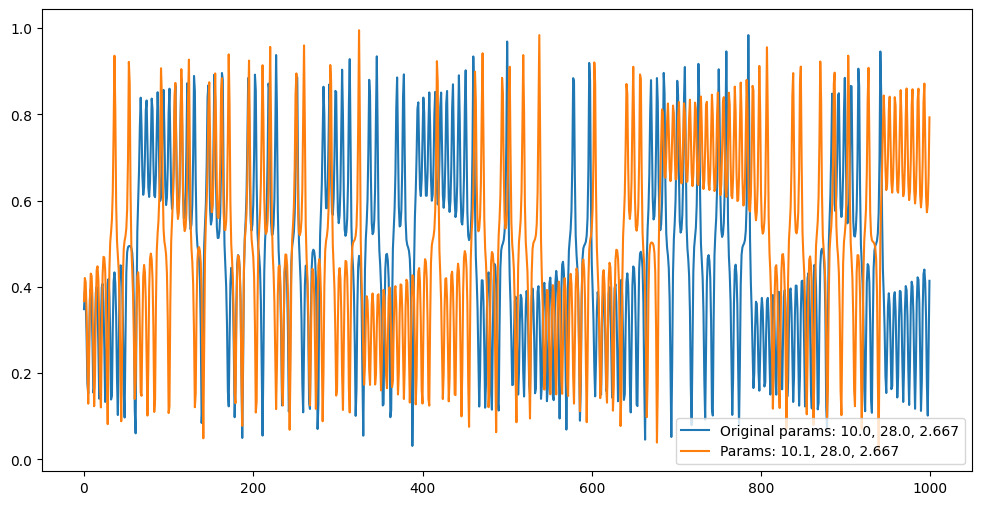

Computing matrix of Z-vectors:   0%|          | 0/10000 [00:00<?, ?it/s]

Predictions:   0%|          | 0/50 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Demon predictions:   0%|          | 0/50 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

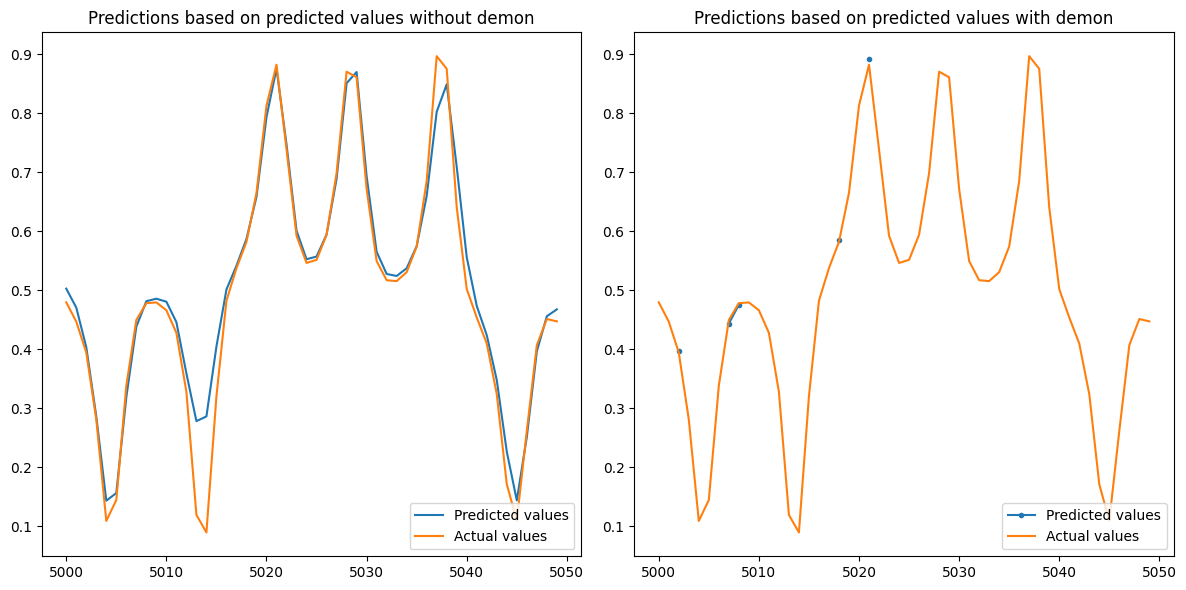

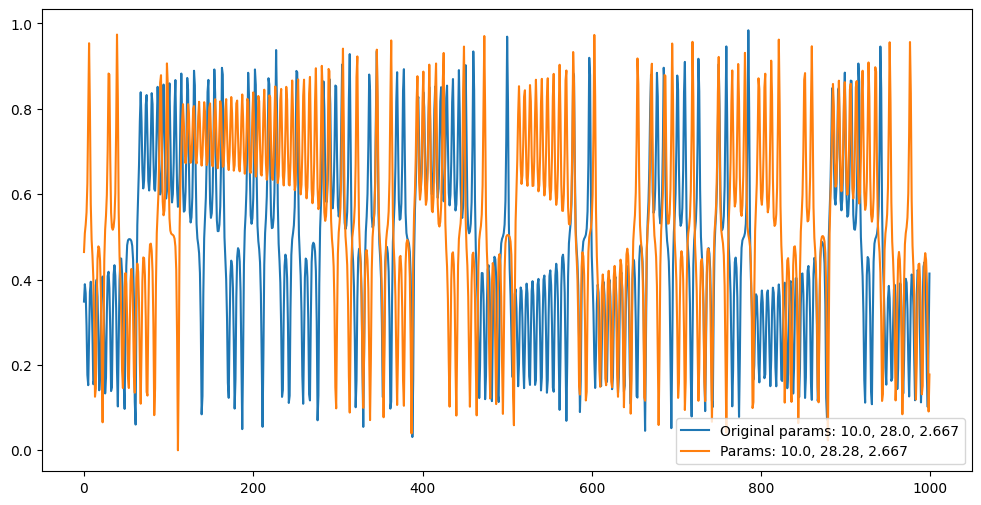

Computing matrix of Z-vectors:   0%|          | 0/10000 [00:00<?, ?it/s]

Predictions:   0%|          | 0/50 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Demon predictions:   0%|          | 0/50 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

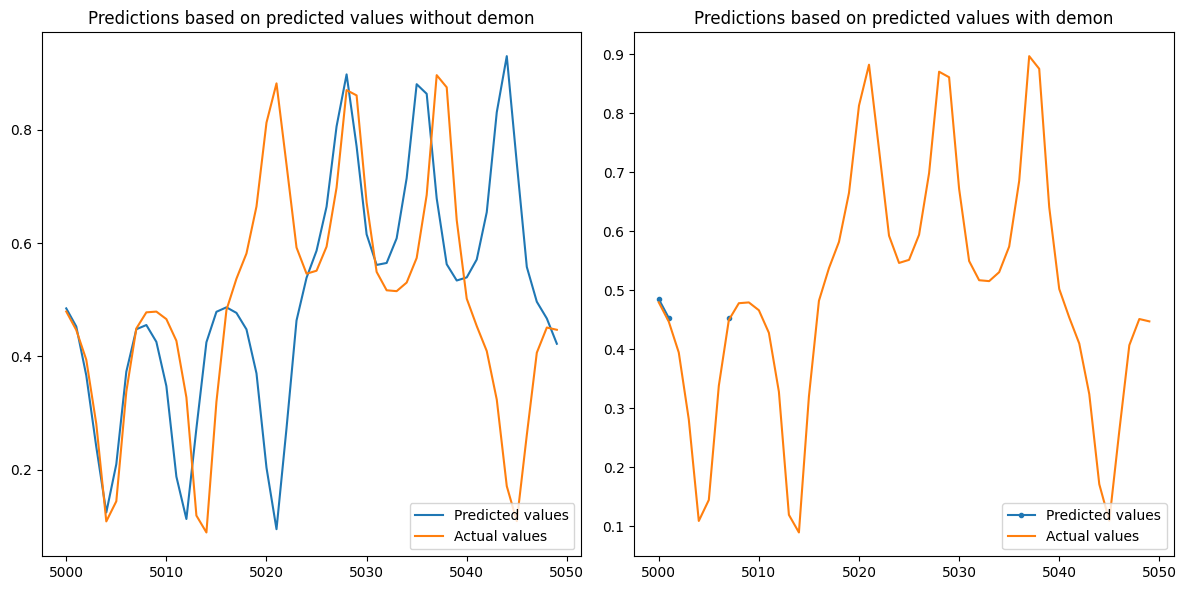

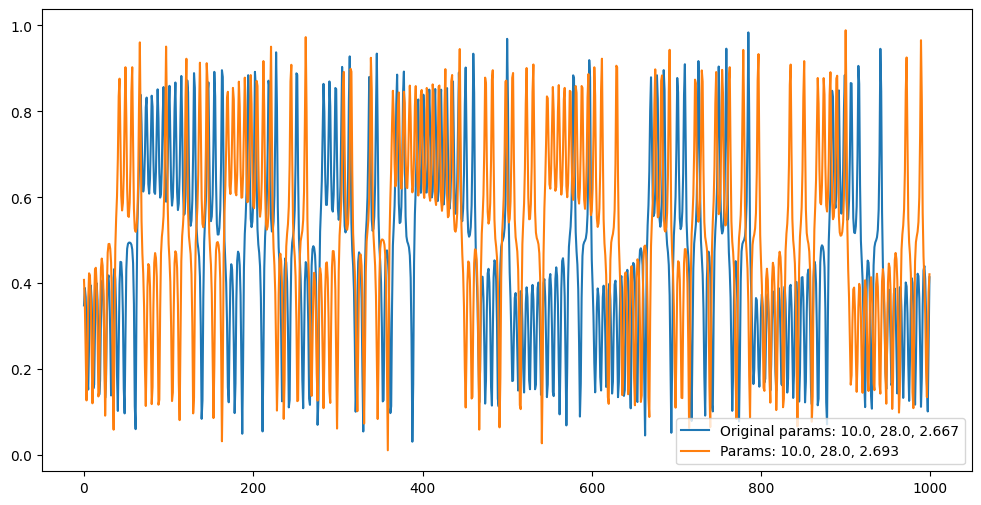

Computing matrix of Z-vectors:   0%|          | 0/10000 [00:00<?, ?it/s]

Predictions:   0%|          | 0/50 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Demon predictions:   0%|          | 0/50 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

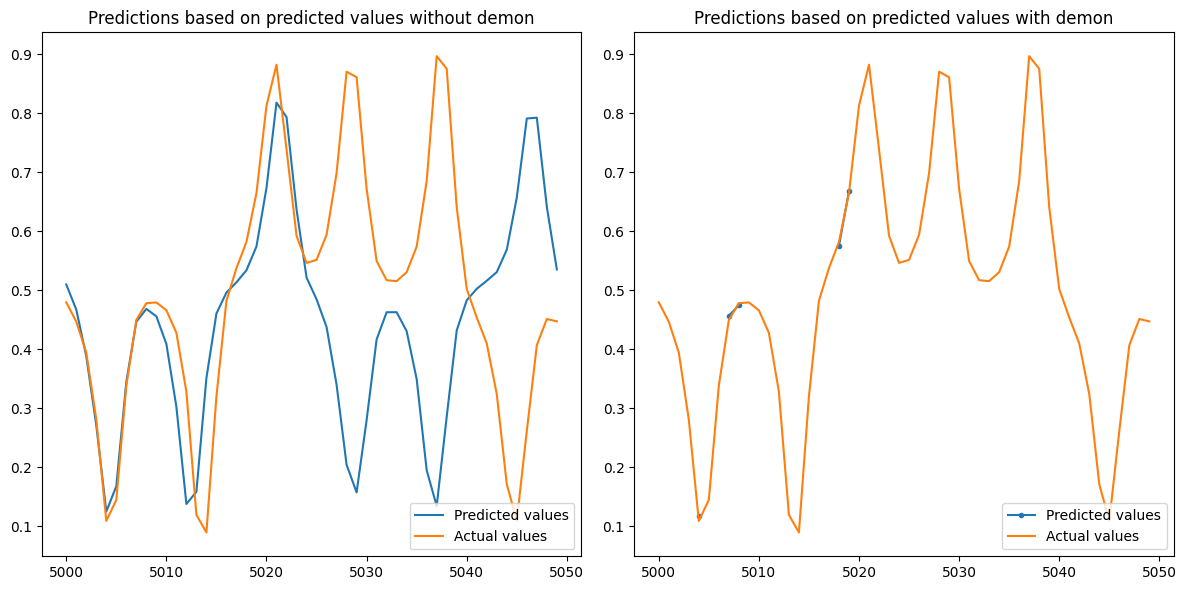

In [13]:
for params in params_list[3:]:
    x = get_data()
    y = get_data(*params) # train data

    plt.figure(figsize=(12, 6))
    plt.plot(x[-1000:], label="Original params: 10.0, 28.0, 2.667")
    plt.plot(y[-1000:], label=f"Params: {round(params[0], 3)}, {round(params[1], 3)}, {round(params[2], 3)}")
    plt.legend(loc="lower right")
    plt.show()

    # Splitting data
    points_number = y.shape[0]

    # Calculates matrix of patterns' arrays
    z_vectors_list = []
    for i in tqdm(range(patterns.shape[0]), desc="Computing matrix of Z-vectors", leave=False):
        z_vectors_list.append(sample_z_vector(patterns[i]))

    predicted_points_number = 50

    predictions_based_on_predicted = predict_on_predicted(z_vectors_list, predicted_points_number)
    demon_predictions = predict_with_demon(z_vectors_list, predicted_points_number)

    plot_2_graphs(predictions_based_on_predicted, demon_predictions, predicted_points_number)